## Unimodal scAAE

For counting data, such as scRNAseq

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import os
import datetime
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from tqdm import trange
import seaborn as sns

seed = 42
torch.manual_seed(seed)
import random
random.seed(seed)
np.random.seed(seed)

## Define NNs and useful functions/classes

In [2]:
# Encoder / Generator
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim_list):  # last item is LATENT SPACE
        super(Encoder, self).__init__()

        self.transformations = nn.ModuleList()
        self.transformations.append(nn.Linear(in_features=input_dim,
                                              out_features=hidden_dim_list[0]))

        for i in range(len(hidden_dim_list)):
            if i == len(hidden_dim_list)-1:
                dim = hidden_dim_list[-1]
                self.transformations.append(nn.Linear(in_features=dim,
                                                      out_features=hidden_dim_list[-1]))

            else:
                in_dim, out_dim = hidden_dim_list[i], hidden_dim_list[i+1]
                self.transformations.append(nn.Linear(in_features=in_dim,
                                                      out_features=out_dim))

    def forward(self, x):
        for i, transform in enumerate(self.transformations):
            if i == len(self.transformations)-1:
                x = transform(x)
                # No leaky relu at the end

            else:
                x = transform(x)
                x = F.leaky_relu(x, negative_slope=0.2)
        return x
    
class Decoder(nn.Module):
    # Input_dim is the original dimensionality
    def __init__(self, input_dim, hidden_dim_list):
        super(Decoder, self).__init__()

        hidden_dim_list.reverse()  # Reverse the list to be the inverse of Net 1
        self.reverse_transformations = nn.ModuleList()

        for i in range(len(hidden_dim_list)):
            if i == len(hidden_dim_list)-1:
                dim = hidden_dim_list[-1]
                self.reverse_transformations.append(
                    nn.Linear(in_features=dim, out_features=input_dim))

            else:
                in_dim, out_dim = hidden_dim_list[i], hidden_dim_list[i+1]
                self.reverse_transformations.append(
                    nn.Linear(in_features=in_dim, out_features=out_dim))

    def forward(self, x):
        for i, transform in enumerate(self.reverse_transformations):
            x = transform(x)
            # RNA preprocessed has negative values
            x = F.leaky_relu(x, negative_slope=0.2)

        return x


class Discriminator(nn.Module):
    def __init__(self, latent_dim, dim=750):
        super(Discriminator, self).__init__()
        self.lin1 = nn.Linear(latent_dim, dim)
        self.lin2 = nn.Linear(dim, dim)
        self.lin3 = nn.Linear(dim, dim//4)
        self.lin4 = nn.Linear(dim//4, 1)

    def forward(self, x):
        x = F.dropout(self.lin1(x), p=0.2, training=self.training)
#         x = F.leaky_relu(x, negative_slope=0.2)
        x = F.relu(x)
        x = F.dropout(self.lin2(x), p=0.2, training=self.training)
#         x = F.leaky_relu(x, negative_slope=0.2)
        x = F.relu(x)
        x = F.dropout(self.lin3(x), p=0.2, training=self.training)
        x = F.leaky_relu(x, negative_slope=0.2) # Para que haya valores menores que 0 antes de lin4 y sigmoid
#         return F.sigmoid(self.lin3(x))
        return torch.sigmoid(self.lin4(x))

In [3]:
# class AAE
# combinar los parametros de las 3 en esta

In [4]:
class PandasDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.data = torch.tensor(df.values).to(device)
        
    def __getitem__(self, index):
        x = self.data[index]
        return x
    
    def __len__(self):
        return len(self.data)

In [5]:
def train_AAE(train_loader, args):
    print("Starting training of the AAE model")
    initial_time = datetime.datetime.now()
    
    # train
    losses = {"reconstruction_loss": [], "discriminator_loss": [], "distribution_loss": []}
    encoder = args["encoder"]
    decoder = args["decoder"]
    discriminator = args["discriminator"]
    
     # Encoder/decoder optimizers
#     decoder_optimizer = args["decoder_optimizer"]
#     encoder_optimizer = args["encoder_optimizer"]
    autoencoder_optimizer = args["autoencoder_optimizer"]
    # Regularizers optimizers
    encoder_optimizer_generator = args["encoder_optimizer_generator"]
    discriminator_optimizer = args["discriminator_optimizer"]
 
    for epoch in trange(args["epochs"], desc="Training", unit="Epoch"):
        total_reconstruction_loss = 0
        total_discriminator_loss = 0
        total_distribution_loss = 0
        
        encoder.train()
        decoder.train()
        discriminator.train()
        
        for batch in train_loader:
            batch.to(args["device"])
            # Zero grad everything
#             decoder_optimizer.zero_grad()
#             encoder_optimizer.zero_grad()

            autoencoder_optimizer.zero_grad()
            encoder_optimizer_generator.zero_grad()
            discriminator_optimizer.zero_grad()
            
            # Embed and reconstruct - Normal autoencoder behaviour
            z = encoder(batch)
            reconstruction = decoder(z)
            
            # Compute loss and backward call
            reconstruction_loss = F.mse_loss(batch, reconstruction)
            reconstruction_loss.backward()

            autoencoder_optimizer.step() 
#             decoder_optimizer.step()
#             encoder_optimizer.step()
            
            # Now let's use and train the discriminator
            encoder.eval()
            
#             real_normal = torch.randn(z.shape).to(args["device"])
            if args["distribution"] == "normal":
#                 print("Using Normal distribution with parameters: 0, 1")
                dist = torch.distributions.Normal(0,1)
                real_distribution = dist.sample(z.shape).to(args["device"])
                
            elif args["distribution"] == "uniform":
#                 print("Using Uniform distribution with parameters: -5, 5")
                dist = torch.distributions.Uniform(-5,5)
                real_distribution = dist.sample(z.shape).to(args["device"])
                
            elif args["distribution"] == "gamma":
#                 print("Using Gamma distribution with parameters: 7.5, 1")
                dist = torch.distributions.Gamma(7.5, 1)
                real_distribution = dist.sample(z.shape).to(args["device"])
            # https://docs.pyro.ai/en/stable/_modules/pyro/distributions/zero_inflated.html
            # Zero inflated distributions
            
            real_discriminator_prediction = discriminator(real_distribution)
            
            fake_distribution = encoder(batch)
            fake_discriminator_prediction = discriminator(fake_distribution)
            
            # BCELoss instead of BCEWithLogitsLoss
            
            bce_loss = nn.BCEWithLogitsLoss(reduction="mean")
#             discriminator_loss = bce_loss(real_discriminator_prediction,
#                                          fake_discriminator_prediction)
            discriminator_loss_real = nn.BCELoss()(real_discriminator_prediction,
                                         torch.ones(real_discriminator_prediction.shape).to(args["device"]))
    
            discriminator_loss_fake = nn.BCELoss()(fake_discriminator_prediction,
                                         torch.zeros(real_discriminator_prediction.shape).to(args["device"])) 
        
            discriminator_loss = discriminator_loss_real + discriminator_loss_fake
            # Quiza haya que usar dos instancias de bce_loss?
            discriminator_loss.backward()
            discriminator_optimizer.step()
            
            # Train again the encoder (generator) to fit the imposed distribution
            
# EL PROBLEMA TIENE QUE SER EL LOSS, QUE EL DISTRIBUTION LOSS NO PARECE HACER MUCHA COSA Y HABRIA QUE ASEGURARSE DE QUE
# EL REAL DISTRIBUTION ES PREDICHO COMO 1 (TARGET DEL BCE) Y EL OTRO COMO 0(TARGET DE OTRO BCE)
            
            encoder.train()

            z_fake_distribution = encoder(batch)
            fake_discriminator_prediction = discriminator(z_fake_distribution)
            
#             distribution_loss = -torch.mean(torch.log(fake_discriminator_prediction)) # Add "+ 1e-15" if it gives problems
            distribution_loss = nn.BCELoss()(fake_discriminator_prediction,
                                         torch.ones(real_discriminator_prediction.shape).to(args["device"]))
    
            distribution_loss *= 2
            distribution_loss.backward()
            encoder_optimizer_generator.step()
            
            total_reconstruction_loss += reconstruction_loss.item()
            total_discriminator_loss += discriminator_loss.item() 
            total_distribution_loss += distribution_loss.item()
            
#         total_reconstruction_loss /= len(train_loader.dataset)
#         total_discriminator_loss /= len(train_loader.dataset)
#         total_distribution_loss /= len(train_loader.dataset)        

        losses["reconstruction_loss"].append(total_reconstruction_loss)
        losses["discriminator_loss"].append(total_discriminator_loss)
        losses["distribution_loss"].append(total_distribution_loss)

#         if epoch % 10 == 0:
#             test_acc = test(test_loader, model)
#             test_accs.append(test_acc)
#             if test_acc > best_acc:
#                 best_acc = test_acc
#                 best_model = copy.deepcopy(model)
#         else:
#             test_accs.append(test_accs[-1])

#     return test_accs, losses, best_model, best_acc, test_loader

    print(f"Finished training in {datetime.datetime.now()-initial_time}.")

    return losses

## Read in and preprocess data

In [6]:
data_first = sc.read_csv("/...")
# PROBAR CON SIMULATED DATA A VER
sc.pp.normalize_total(data_first, target_sum=1e4)
# data_first.to_df().head()
sc.pp.log1p(data_first)
sc.pp.scale(data_first, max_value=10)

standard_first_df = data_first.to_df()
standard_first_df.head()

,HBG1,HBA2,HBA1,HBG2,HBB,HBM,AHSP,PPBP,MOUSE-Acta2,GYPA,...,RP13-516M14.4,ASAP2,FBXO8,NUP62CL,SMAD1,PSMD6,CD33,GLIPR1,STAM,TBX21
CTGTTTACACCGCTAG,-0.104156,-0.045151,0.310579,0.004218,0.009294,-0.162314,-0.166817,0.122146,0.699803,-0.107077,...,-0.110441,-0.076785,-0.096632,-0.061886,-0.064171,-0.339979,-0.267547,-0.596373,-0.121413,-0.173885
CTCTACGGTGTGGCTC,0.077538,-0.069485,0.269898,-0.029448,-0.026223,-0.162314,0.969520,0.560123,2.493485,-0.107077,...,-0.110441,-0.076785,-0.096632,-0.061886,-0.064171,-0.339979,-0.267547,-0.596373,-0.121413,-0.173885
AGCAGCCAGGCTCATT,-0.125581,-0.068667,0.149934,0.247659,-0.025005,-0.162314,-0.166817,-0.283777,1.784945,-0.107077,...,-0.110441,-0.076785,-0.096632,-0.061886,-0.064171,-0.339979,-0.267547,-0.596373,-0.121413,-0.173885
GAATAAGAGATCCCAT,0.196838,0.285211,0.559936,0.063534,0.250454,-0.162314,0.453908,-0.283777,1.817608,-0.107077,...,-0.110441,-0.076785,-0.096632,-0.061886,-0.064171,-0.339979,-0.267547,-0.596373,-0.121413,-0.173885
GTGCATAGTCATGCAT,0.294771,0.210189,0.610698,0.155798,0.351661,0.588310,0.581618,0.638190,4.224497,-0.107077,...,-0.110441,-0.076785,-0.096632,-0.061886,-0.064171,-0.339979,-0.267547,-0.596373,-0.121413,-0.173885


## Set up the nets - Normal distribution

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# EPS = 1e-15
latent_dim = 2
input_dim = 2000
hidden_dim_list = [1500, 1000, 500, 250, 100, 32, 16, 8, latent_dim]
epochs = 3000
batch_size = 252

encoder = Encoder(input_dim=input_dim, hidden_dim_list=hidden_dim_list).to(device)
decoder = Decoder(input_dim=input_dim, hidden_dim_list=hidden_dim_list).to(device)
discriminator = Discriminator(latent_dim=latent_dim, dim=750).to(device)

general_lr = 0.0001
regularizer_lr = 0.00008

# Encoder/decoder optimizers
# decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=general_lr)
# encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=general_lr)
autoencoder_optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=general_lr)

# Regularizers optimizers
encoder_optimizer_generator = torch.optim.Adam(encoder.parameters(), lr=regularizer_lr)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=regularizer_lr)

# Set the args dict
args = {
    "encoder": encoder,
    "decoder": decoder,
    "discriminator": discriminator,
#     "decoder_optimizer": decoder_optimizer,
#     "encoder_optimizer": encoder_optimizer,
    "autoencoder_optimizer": autoencoder_optimizer,
    "encoder_optimizer_generator": encoder_optimizer_generator,
    "discriminator_optimizer": discriminator_optimizer,
    "epochs": epochs,
    "device": device  ,
    "distribution": "normal"
}

# https://github.com/neale/Adversarial-Autoencoder/blob/master/train.py

## Actual training - Normal Distribution

In [8]:
data = PandasDataset(standard_first_df)
train_loader = DataLoader(dataset=data, batch_size=batch_size, 
                          shuffle=True, num_workers=0)

In [9]:
losses = train_AAE(train_loader, args)

Starting training of the AAE model


Training: 100%|██████████| 3000/3000 [23:04<00:00,  2.17Epoch/s]

Finished training in 0:23:04.914329.


## Loss plots - Normal distribution

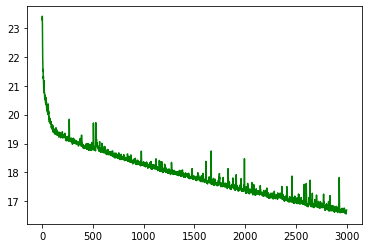

In [10]:
plt.plot(losses["reconstruction_loss"], 'g')

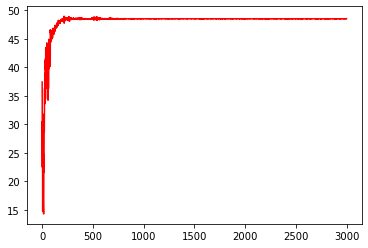

In [11]:
plt.plot(losses["discriminator_loss"], 'r')
# plt.xlim([0,100])

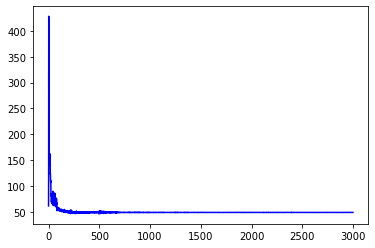

In [12]:
plt.plot(losses["distribution_loss"], 'b')

## Embeddings - Normal distribution

In [13]:
clusters = pd.read_csv("...")

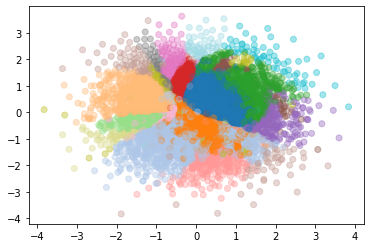

In [14]:
latent = encoder(torch.tensor(standard_first_df.values).to(device))
latent = latent.cpu().detach().numpy()

plt.scatter(latent[:,0],latent[:,1], alpha=.4, c=clusters["Cluster Nr"], cmap="tab20")

## Clustering - Normal distribution

/data/leuven/331/vsc33180/miniconda3/envs/pytorch2/lib/python3.8/site-packages/anndata/utils.py:141: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")
/data/leuven/331/vsc33180/miniconda3/envs/pytorch2/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


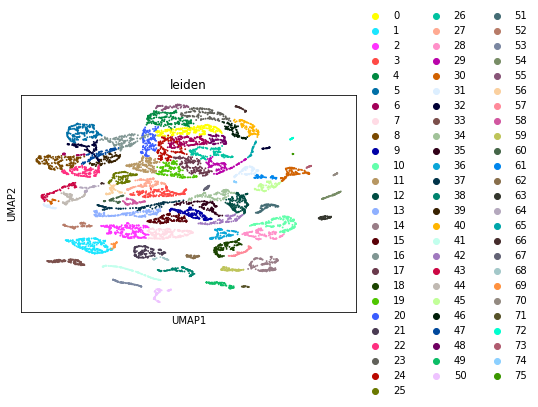

In [15]:
from anndata._core.anndata import AnnData

latent_df = pd.DataFrame(latent, columns=["LatentDim{}".format(i+1) for i in range(latent.shape[1])])
latent_df["Clusters"] = clusters["Cluster Nr"].apply(lambda x: int(x))
combined_data = AnnData(X=latent_df)

sc.tl.pca(combined_data, svd_solver='arpack', n_comps=latent_dim)
# combined_data.obsm["X_pca"] = latent
sc.pp.neighbors(combined_data, n_neighbors=10, n_pcs=latent_dim)
sc.tl.umap(combined_data)
sc.tl.leiden(combined_data)
sc.pl.umap(combined_data, color=['leiden'])

## Distribution check - Normal

In [16]:
dist = torch.distributions.Normal(0,1)
real_distribution = dist.sample([standard_first_df.values.shape[0], latent_dim]).to(device)
latent = encoder(torch.tensor(standard_first_df.values).to(device))

discriminator.eval()
real_discriminator = discriminator(real_distribution)
fake_discriminator = discriminator(latent)

Text(0.5, 1.0, 'Discriminator accuracy on REAL distribution')

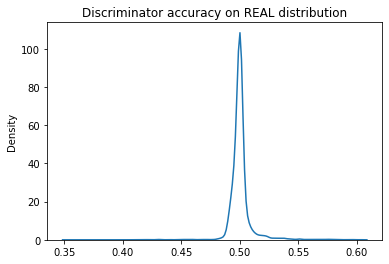

In [17]:
real_np = real_discriminator.cpu().detach().numpy()
# np.arange(8617) + 0.3
sns.kdeplot(real_np.flatten())
plt.title("Discriminator accuracy on REAL distribution")
# sns.displot(x=real_np.flatten(), kind="hist", bins=40)
# real_np.flatten()#.tolist()

Text(0.5, 1.0, 'Discriminator accuracy on FAKE distribution')

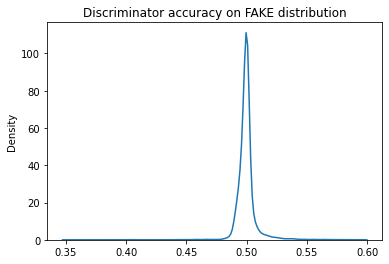

In [18]:
fake_discriminator.cpu().detach().numpy()
fake_np = fake_discriminator.cpu().detach().numpy()
sns.kdeplot(fake_np.flatten())
plt.title("Discriminator accuracy on FAKE distribution")

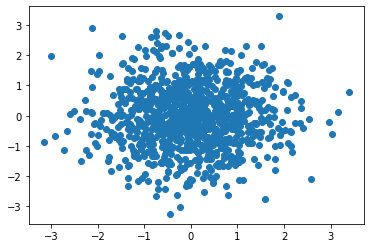

In [19]:
a = torch.randn([1000,2])
plt.scatter(a[:,0], a[:,1])

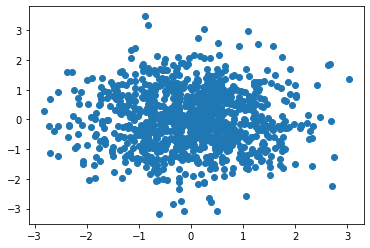

In [20]:
a = dist.sample([1000,2])
plt.scatter(a[:,0], a[:,1])